In [1]:
import cv2 as cv
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

In [2]:
def load_image():
    # image load
    img = cv.imread("../../Data/graffiti.png")

    # convert to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    return img

In [3]:
# calculate the square Euclidian distance
def calculate_distance(a, b):
    # get the differences
    dis = a - b
    
    # square the distance
    sqr_dis = dis * dis    
    
    return np.sum(sqr_dis) # return square Euclidian distance    

In [4]:
# calculate centroid

def calculate_centroid(pixel_values, assigned_k):

    # all uniqe value of k = 1,2,..., K
    unique_k = np.unique(assigned_k)

    # store the value of k, and calculated centrioed
    centroid_map = {}

    for k in unique_k:
        # get all indices of cluster k
        indices = (np.where(assigned_k == k))[0]

        # all values of cluster k
        values = np.take(pixel_values, indices, axis=0)

        val_1 = values[:, 0]
        val_2 = values[:, 1]
        val_3 = values[:, 2]

        # calculate the centroid of each k
        centroid = [np.mean(val_1), np.mean(val_2), np.mean(val_3)]
        
        # store the centroid, with the cluster id
        centroid_map[k] = centroid
        
    return centroid_map

In [5]:
# update the cluster value

def update_clusters(K, itt, pixel_values, centroid_map, dist_k):

    for i in range(pixel_values.shape[0]):

        #print(pixel_values[i, :])
        data_point = pixel_values[i, :]

        #set min dist as Inf
        min_dist = 99999999999999
        min_k = 9999999999

        for k, centroid in centroid_map.items():
            # calculate the distance between point, and centroid
            dist = calculate_distance(data_point, centroid)

            # Update the minimum distance
            if min_dist > dist:
                min_dist = dist
                min_k = k
        
        # assign the pixel to a new cluster
        assigned_k[i] = min_k
        dist_k[i] = math.sqrt(min_dist)
        
        if i != 0 and i%500==0:
            print(end='\r')
            print(f'For K = {K}, Computing {round((i*100) / (pixel_values.shape[0]), 3)} % of Itteration {itt}', end= ' ')
    
    return assigned_k, dist_k

In [8]:
def updated_iamge(pixel_values, assigned_k, centroid_values):

    # update the pixel values

    modified_pixels = np.zeros(pixel_values.shape)

    for i in range(pixel_values.shape[0]):

        # get current cluster ID
        ind = assigned_k[i]

        # get the centriod value
        new_color = centroid_values[ind]

        # assign new color value in the picture
        modified_pixels[i, :] = new_color


    # firslt convert all float to unit8 and reshape the image shape
    result_image = (np.uint8(modified_pixels)).reshape((img.shape))
    
    return result_image

In [9]:
# Load the image
img = load_image()

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = img.reshape((-1, 3))

# convert to float
pixel_values = np.float32(pixel_values)

# set all the value for number of clusters
clusters = [8, 16, 32, 64] 

#error reduce rate
error_reduce = {}

#all output images
images_result = {}

for K in clusters:
    
    #error reduce values
    error_val = []

    # cluster initialization
    assigned_k = [] 

    # this code confirm that we divide the assignment into K different cluster
    while(True):
        assigned_k = np.random.randint(1,(K+1), pixel_values.shape[0])

        if len(np.unique(assigned_k)) == K:
            break


    # init Euclidian distance
    dist_k = np.zeros(pixel_values.shape[0])

    last_wcd = 0 

    for i in range(1, 11):    
        # calculate centroid
        centroid_info = calculate_centroid(pixel_values, assigned_k)

        # re-assigned k with minimum value
        assigned_k, dist_k = update_clusters(K, i, pixel_values, centroid_info, dist_k)

        within_cluster_diff = np.sum(dist_k)

        if i == 1:
            last_wcd = within_cluster_diff
            continue

        error_rate = abs(last_wcd - within_cluster_diff) * 100 / last_wcd
        
        error_val.append(error_rate)

        last_wcd = within_cluster_diff

        if error_rate < 2:
            break
            
    print(end='\r')       
    print(f'For K = {K}, Avgerage Euclidian Distance of each pixel is: {np.mean(dist_k)}')
    
    # store the error reduction values
    error_reduce[K] = error_val
    
    #store the output images
    images_result[K] = updated_iamge(pixel_values, assigned_k, centroid_info)
    

For K = 8, Avgerage Euclidian Distance of each pixel is: 23.319030895783964
For K = 16, Avgerage Euclidian Distance of each pixel is: 19.408708529586693
For K = 32, Avgerage Euclidian Distance of each pixel is: 19.9627142457319
For K = 64, Avgerage Euclidian Distance of each pixel is: 15.503528103927058


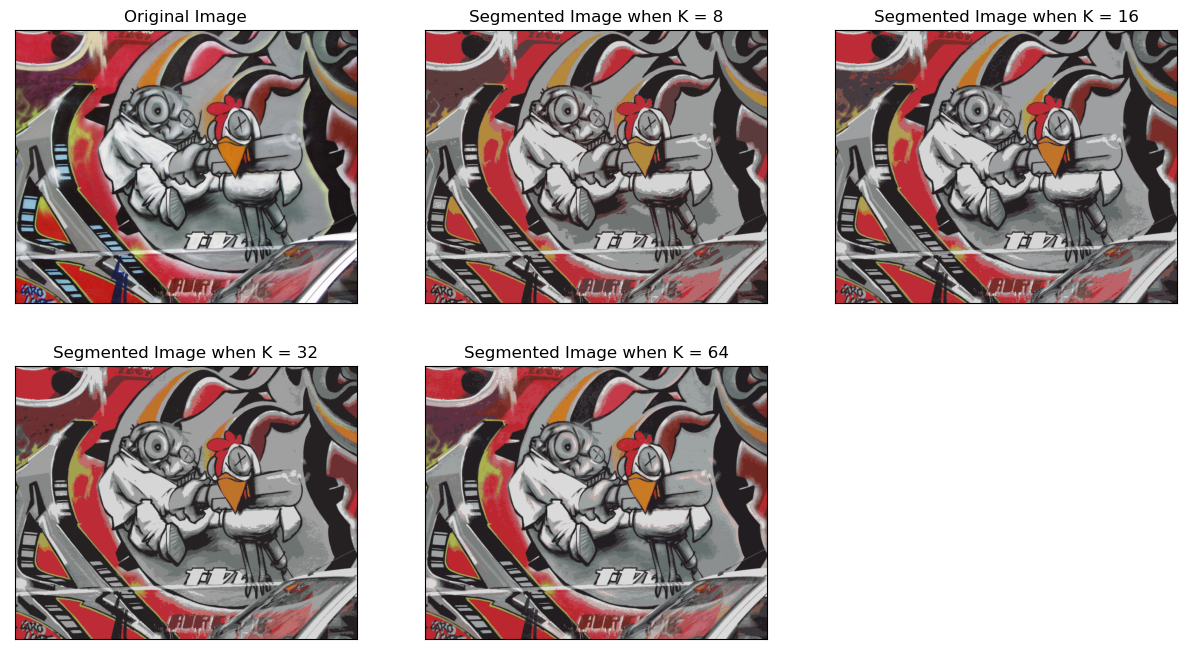

In [16]:
# Draw all the images

plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

ind = 2
for K in clusters:
    plt.subplot(2, 3, ind)
    plt.imshow(images_result[K])
    plt.title('Segmented Image when K = %i' % K)
    plt.xticks([]), plt.yticks([])
    
    ind = ind + 1

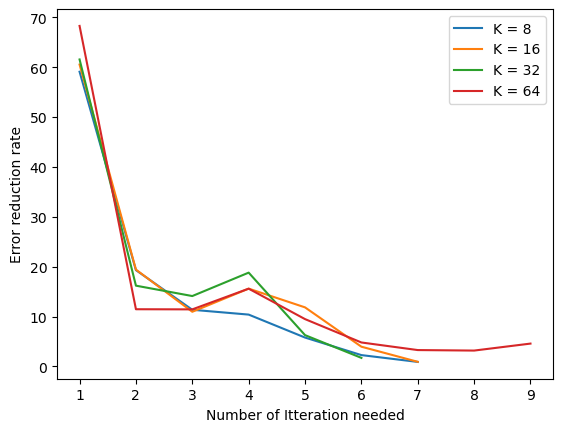

In [13]:
# Draw the error reduction rate for different value of K

for K in clusters:
    x = list(range(1, len(error_reduce[K])+1))
    y = error_reduce[K]

    plt.plot(x, y, label = f"K = {K}")

plt.legend()
plt.xlabel('Number of Itteration needed')
plt.ylabel('Error reduction rate')

plt.show()

### a) What are the problems of this clustering algorithm?

The main limitation of this clustering algorith is we have to predifine the value of K. As a result, we need to run the algorithm several times to get the optimal number of K. 

### b) How can I improve the results?

One approach is to make a large set of K. Make a parallel pipeline to run the algorithm and compute total cluster differences. And then pick the optimal value of K.